# 8-bit Bias Bounty

## Install Requirements

In [603]:
#!conda install -y pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
#!conda install -y -c conda-forge matplotlib
#!pip install Pillow scikit-learn tqdm tensorboard
#!pip install dlib face_recognition
#!pip install opencv-python pyyaml seaborn optuna plotly

In [606]:
from train import TransferLearning

In [607]:
m = TransferLearning.load('2b4a17bf-e34e-48d6-a72b-341a07352f15')

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 1.09 GiB already allocated; 12.69 MiB free; 1.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
%load_ext autoreload

In [2]:
import torch

from torchvision import models

import sqlite3

from joblib import load
import numpy as np

import pandas as pd

from PIL import Image

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.metrics import confusion_matrix

import face_recognition

/home/justin/miniconda3/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

In [4]:
%autoreload 2

In [5]:
from data_set import BiasBountyDataset

In [6]:
def show_image(im, title=None):
    plt.imshow(((im + im.min().abs()) / (im.max() - im.min())).swapaxes(0, 2).swapaxes(0, 1))
    if title:
        plt.title(title) 

In [7]:
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

In [8]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

In [44]:
from pprint import pprint

## Find ImageNet Images

Instead of relying on the model to perform randomly on ImageNet images, we'll predict whether an image is out-of-distribution. To do this, we need labels on which images from the training set are non-people. To create these labels, we'll use a combination of YOLOv5 and dlib (via the face_recognition package).

In [604]:
image = face_recognition.load_image_file("raw_data/train/TRAIN0001.png")
face_locations = face_recognition.face_locations(image)

In [474]:
c = pd.read_csv('data/train/labels.csv')

In [475]:
c.yolo_result.value_counts()

1 person                            3720
2 persons                            110
1 person, 1 tie                       78
1 dog                                 75
1 person, 1 toothbrush                70
                                    ... 
1 cup, 1 spoon, 1 cake, 3 chairs       1
1 cup, 1 chair, 1 couch, 1 tv          1
1 bowl, 1 broccoli, 2 carrots          1
1 wine glass, 3 knifes, 2 cakes        1
10 persons, 5 horses                   1
Name: yolo_result, Length: 867, dtype: int64

In [477]:
c.yolo_result.str.contains('person').value_counts()

True     4612
False    1533
Name: yolo_result, dtype: int64

In [478]:
c[c.yolo_result.isna()]

,name,skin_tone,gender,age,n_faces,yolo_result
2,TRAIN0004.png,monk_3,male,0_17,0,NaN
5,TRAIN0007.png,monk_2,female,18_30,0,NaN
8,TRAIN0012.png,monk_4,male,31_60,0,NaN
11,TRAIN0016.png,monk_8,female,0_17,0,NaN
16,TRAIN0024.png,monk_2,female,18_30,0,NaN
...,...,...,...,...,...,...
8538,TRAIN9986.png,monk_7,female,18_30,0,NaN
8539,TRAIN9988.png,monk_6,male,61_100,0,NaN
8540,TRAIN9989.png,monk_8,female,18_30,0,NaN
8542,TRAIN9992.png,monk_5,female,31_60,0,NaN


In [484]:
c = pd.read_csv('data/train/labels.csv')

In [485]:
c.yolo_result.value_counts()

1 person                                                        3734
2 persons                                                        120
1 bird                                                            89
1 person, 1 tie                                                   86
1 person, 1 cell phone                                            85
                                                                ... 
1 cup, 1 knife, 2 potted plants, 1 microwave, 1 oven, 1 sink       1
1 suitcase, 1 chair                                                1
1 cup, 1 fork, 1 spoon, 1 cake, 2 chairs                           1
2 chairs, 1 bed, 1 tv, 1 keyboard                                  1
10 persons, 3 horses                                               1
Name: yolo_result, Length: 917, dtype: int64

In [486]:
c.yolo_result.str.contains('person').value_counts()

True     4720
False    1555
Name: yolo_result, dtype: int64

In [512]:
c[c['name'] == 'TRAIN1700.png']

,name,skin_tone,gender,age,n_faces,yolo_result
2796,TRAIN1700.png,monk_5,male,18_30,0,1 donut


In [529]:
predicted_non_ppl = c[~((~c.yolo_result.isna()) & (c.yolo_result.str.contains('person'))) & (~c.yolo_result.isna())]

In [530]:
true_ppl_but_predicted_non_ppl = [
    'TRAIN0049.png', 'TRAIN0194.png', 'TRAIN0355.png', 'TRAIN0382.png',
    'TRAIN0460.png', 'TRAIN0581.png', 'TRAIN0584.png', 'TRAIN0662.png',
    'TRAIN0690.png', 'TRAIN0880.png', 'TRAIN0887.png', 'TRAIN0940.png',
    'TRAIN0969.png', 'TRAIN10108.png', 'TRAIN10143.png', 'TRAIN10399.png',
    'TRAIN10538.png', 'TRAIN10691.png', 'TRAIN10706.png', 'TRAIN10734.png',
    'TRAIN10754.png', 'TRAIN10830.png', 'TRAIN1104.png', 'TRAIN11042.png',
    'TRAIN11129.png', 'TRAIN1126.png', 'TRAIN11294.png', 'TRAIN1137.png',
    'TRAIN11441.png', 'TRAIN11760.png', 'TRAIN11794.png', 'TRAIN11826.png',
    'TRAIN11849.png', 'TRAIN11850.png', 'TRAIN11880.png', 'TRAIN1189.png',
    'TRAIN11941.png', 'TRAIN11951.png', 'TRAIN11963.png', 'TRAIN12107.png',
    'TRAIN1325.png', 'TRAIN1415.png', 'TRAIN1532.png', 'TRAIN1629.png',
    'TRAIN1633.png', 'TRAIN1681.png', 'TRAIN1700.png', 'TRAIN1857.png',
    'TRAIN1879.png', 'TRAIN1926.png', 'TRAIN1972.png', 'TRAIN2014.png',
    'TRAIN2334.png', 'TRAIN2505.png', 'TRAIN2756.png', 'TRAIN2835.png',
    'TRAIN2890.png', 'TRAIN3001.png', 'TRAIN3053.png', 'TRAIN3127.png',
    'TRAIN3129.png', 'TRAIN3188.png', 'TRAIN3313.png', 'TRAIN3513.png',
    'TRAIN3700.png', 'TRAIN3882.png', 'TRAIN3923.png', 'TRAIN3961.png',
    'TRAIN3981.png', 'TRAIN4055.png', 'TRAIN4125.png', 'TRAIN4290.png',
    'TRAIN4863.png', 'TRAIN5080.png', 'TRAIN5112.png', 'TRAIN5586.png',
    'TRAIN5789.png', 'TRAIN5964.png', 'TRAIN6017.png', 'TRAIN6142.png',
    'TRAIN6263.png', 'TRAIN6266.png', 'TRAIN6312.png', 'TRAIN6314.png',
    'TRAIN6324.png', 'TRAIN6358.png', 'TRAIN6392.png', 'TRAIN6422.png',
    'TRAIN6646.png', 'TRAIN6835.png', 'TRAIN7074.png', 'TRAIN7229.png',
    'TRAIN7279.png', 'TRAIN7318.png', 'TRAIN7414.png', 'TRAIN7586.png',
    'TRAIN7606.png', 'TRAIN7626.png', 'TRAIN7780.png', 'TRAIN7920.png',
    'TRAIN8250.png', 'TRAIN8274.png', 'TRAIN8289.png', 'TRAIN8291.png',
    'TRAIN8443.png', 'TRAIN8624.png', 'TRAIN8715.png', 'TRAIN8851.png',
    'TRAIN8872.png', 'TRAIN9090.png', 'TRAIN9232.png', 'TRAIN9267.png',
    'TRAIN9359.png', 'TRAIN9480.png', 'TRAIN9482.png'
]

In [534]:
true_non_ppl = c[c['name'].isin(set(predicted_non_ppl['name'].values) - set(true_ppl_but_predicted_non_ppl))]

In [535]:
true_non_ppl

,name,skin_tone,gender,age,n_faces,yolo_result
0,TRAIN0001.png,monk_1,female,18_30,0,1 vase
6,TRAIN0009.png,monk_8,female,18_30,0,1 sheep
9,TRAIN0013.png,monk_6,male,18_30,0,1 bowl
14,TRAIN0021.png,monk_7,male,18_30,0,"1 bicycle, 1 sports ball, 1 laptop, 1 mouse, 1..."
15,TRAIN0022.png,monk_8,female,0_17,0,"1 spoon, 1 chair, 1 potted plant"
...,...,...,...,...,...,...
8510,TRAIN9949.png,monk_2,female,18_30,0,1 bed
8514,TRAIN9954.png,monk_9,male,61_100,0,1 cup
8537,TRAIN9984.png,monk_2,female,0_17,0,1 surfboard
8540,TRAIN9989.png,monk_8,female,18_30,0,1 potted plant


In [536]:
c['has_person'] = True

In [540]:
c.loc[c['name'].isin(set(true_non_ppl['name'].values)), 'has_person'] = False

In [541]:
c

,name,skin_tone,gender,age,n_faces,yolo_result,has_person
0,TRAIN0001.png,monk_1,female,18_30,0,1 vase,False
1,TRAIN0002.png,monk_6,male,0_17,0,1 person,True
2,TRAIN0004.png,monk_3,male,0_17,0,NaN,True
3,TRAIN0005.png,monk_2,male,0_17,0,4 persons,True
4,TRAIN0006.png,monk_2,female,18_30,0,"1 person, 1 donut",True
...,...,...,...,...,...,...,...
8543,TRAIN9993.png,monk_2,male,18_30,0,1 person,True
8544,TRAIN9995.png,monk_9,female,18_30,0,"1 person, 1 orange",True
8545,TRAIN9996.png,monk_4,female,18_30,0,NaN,True
8546,TRAIN9998.png,monk_5,male,18_30,0,1 cup,False


In [ ]:
for f in ['name'].values:
    i = Image.open(f'data/train/{f}')
    print(f'{f} - {i.size}')
    display(i)

In [524]:
na_yolo_labels_without_ppl = [
    'TRAIN0004.png', 'TRAIN0016.png', 'TRAIN0038.png', 'TRAIN0098.png',
    'TRAIN0105.png', 'TRAIN0145.png', 'TRAIN0147.png', 'TRAIN0158.png',
    'TRAIN0163.png', 'TRAIN0260.png', 'TRAIN0262.png', 'TRAIN0294.png',
    'TRAIN0317.png', 'TRAIN0338.png', 'TRAIN0345.png', 'TRAIN0362.png',
    'TRAIN0364.png', 'TRAIN0390.png', 'TRAIN0391.png', 'TRAIN0412.png',
    'TRAIN0417.png', 'TRAIN0448.png', 'TRAIN0458.png', 'TRAIN0482.png',
    'TRAIN0488.png', 'TRAIN0512.png', 'TRAIN0525.png', 'TRAIN0529.png',
    'TRAIN0537.png', 'TRAIN0545.png', 'TRAIN0571.png', 'TRAIN0574.png',
    'TRAIN0580.png', 'TRAIN0583.png', 'TRAIN0606.png', 'TRAIN0614.png',
    'TRAIN0629.png', 'TRAIN0632.png', 'TRAIN0634.png', 'TRAIN0661.png',
    'TRAIN0697.png', 'TRAIN0703.png', 'TRAIN0707.png', 'TRAIN0760.png',
    'TRAIN0768.png', 'TRAIN0778.png', 'TRAIN0780.png', 'TRAIN0784.png',
    'TRAIN0793.png', 'TRAIN0804.png', 'TRAIN0814.png', 'TRAIN0827.png',
    'TRAIN0851.png', 'TRAIN0892.png', 'TRAIN0899.png', 'TRAIN0918.png',
    'TRAIN0943.png', 'TRAIN0950.png', 'TRAIN0951.png', 'TRAIN0968.png',
    'TRAIN0980.png', 'TRAIN10008.png', 'TRAIN10011.png', 'TRAIN10019.png',
    'TRAIN10026.png', 'TRAIN10035.png', 'TRAIN10037.png', 'TRAIN10047.png',
    'TRAIN10097.png', 'TRAIN10123.png', 'TRAIN10125.png', 'TRAIN10150.png',
    'TRAIN1016.png', 'TRAIN10160.png', 'TRAIN10167.png', 'TRAIN10169.png',
    'TRAIN10170.png', 'TRAIN10177.png', 'TRAIN10248.png', 'TRAIN10257.png',
    'TRAIN10300.png', 'TRAIN10321.png', 'TRAIN10328.png', 'TRAIN10342.png',
    'TRAIN10343.png', 'TRAIN10348.png', 'TRAIN10352.png', 'TRAIN10353.png',
    'TRAIN10367.png', 'TRAIN10414.png', 'TRAIN10421.png', 'TRAIN10429.png',
    'TRAIN10443.png', 'TRAIN10453.png', 'TRAIN10454.png', 'TRAIN10524.png',
    'TRAIN10535.png', 'TRAIN10554.png', 'TRAIN10578.png', 'TRAIN10597.png',
    'TRAIN1065.png', 'TRAIN1066.png', 'TRAIN10716.png', 'TRAIN10724.png',
    'TRAIN10737.png', 'TRAIN10755.png', 'TRAIN10808.png', 'TRAIN10817.png',
    'TRAIN10826.png', 'TRAIN10849.png', 'TRAIN11148.png', 'TRAIN11185.png',
    'TRAIN11187.png', 'TRAIN11191.png', 'TRAIN1120.png', 'TRAIN11229.png',
    'TRAIN11291.png', 'TRAIN11297.png', 'TRAIN11309.png', 'TRAIN11310.png',
    'TRAIN11312.png', 'TRAIN11327.png', 'TRAIN11336.png', 'TRAIN11354.png',
    'TRAIN11367.png', 'TRAIN11433.png', 'TRAIN11500.png', 'TRAIN11506.png',
    'TRAIN11518.png', 'TRAIN11528.png', 'TRAIN11533.png', 'TRAIN11539.png',
    'TRAIN1154.png', 'TRAIN11548.png', 'TRAIN11568.png', 'TRAIN11581.png',
    'TRAIN11586.png', 'TRAIN11605.png', 'TRAIN11613.png', 'TRAIN11626.png',
    'TRAIN11649.png', 'TRAIN11657.png', 'TRAIN11668.png', 'TRAIN1167.png',
    'TRAIN11690.png', 'TRAIN11777.png', 'TRAIN11842.png', 'TRAIN11848.png',
    'TRAIN11856.png', 'TRAIN11859.png', 'TRAIN11860.png', 'TRAIN11910.png',
    'TRAIN11914.png', 'TRAIN11919.png', 'TRAIN11922.png', 'TRAIN11937.png',
    'TRAIN11939.png', 'TRAIN11961.png', 'TRAIN11964.png', 'TRAIN1198.png',
    'TRAIN11984.png', 'TRAIN12019.png', 'TRAIN12031.png', 'TRAIN12039.png',
    'TRAIN12060.png', 'TRAIN12064.png', 'TRAIN12076.png', 'TRAIN12094.png',
    'TRAIN12121.png', 'TRAIN12170.png', 'TRAIN12197.png', 'TRAIN12199.png',
    'TRAIN12215.png', 'TRAIN12222.png', 'TRAIN12227.png', 'TRAIN12228.png',
    'TRAIN12258.png', 'TRAIN12259.png', 'TRAIN12264.png', 'TRAIN12266.png',
    'TRAIN1229.png', 'TRAIN1240.png', 'TRAIN1252.png', 'TRAIN1279.png',
    'TRAIN1306.png', 'TRAIN1312.png', 'TRAIN1376.png', 'TRAIN1388.png',
    'TRAIN1390.png', 'TRAIN1394.png', 'TRAIN1435.png', 'TRAIN1440.png',
    'TRAIN1442.png', 'TRAIN1481.png', 'TRAIN1495.png', 'TRAIN1525.png',
    'TRAIN1542.png', 'TRAIN1555.png', 'TRAIN1560.png', 'TRAIN1585.png',
    'TRAIN1604.png', 'TRAIN1639.png', 'TRAIN1648.png', 'TRAIN1664.png',
    'TRAIN1685.png', 'TRAIN1686.png', 'TRAIN1709.png', 'TRAIN1724.png',
    'TRAIN1750.png', 'TRAIN1757.png', 'TRAIN1802.png', 'TRAIN1810.png',
    'TRAIN1828.png', 'TRAIN1865.png', 'TRAIN1895.png', 'TRAIN1899.png',
    'TRAIN1906.png', 'TRAIN1917.png', 'TRAIN1930.png', 'TRAIN1986.png',
    'TRAIN1998.png', 'TRAIN2000.png', 'TRAIN2023.png', 'TRAIN2026.png',
    'TRAIN2033.png', 'TRAIN2049.png', 'TRAIN2071.png', 'TRAIN2105.png',
    'TRAIN2106.png', 'TRAIN2180.png', 'TRAIN2193.png', 'TRAIN2204.png',
    'TRAIN2247.png', 'TRAIN2322.png', 'TRAIN2343.png', 'TRAIN2355.png',
    'TRAIN2368.png', 'TRAIN2383.png', 'TRAIN2419.png', 'TRAIN2421.png',
    'TRAIN2428.png', 'TRAIN2430.png', 'TRAIN2461.png', 'TRAIN2466.png',
    'TRAIN2472.png', 'TRAIN2504.png', 'TRAIN2568.png', 'TRAIN2674.png',
    'TRAIN2695.png', 'TRAIN2711.png', 'TRAIN2739.png', 'TRAIN2740.png',
    'TRAIN2745.png', 'TRAIN2768.png', 'TRAIN2772.png', 'TRAIN2790.png',
    'TRAIN2808.png', 'TRAIN2811.png', 'TRAIN2844.png', 'TRAIN2871.png',
    'TRAIN2911.png', 'TRAIN2914.png', 'TRAIN2931.png', 'TRAIN2975.png',
    'TRAIN2989.png', 'TRAIN3036.png', 'TRAIN3040.png', 'TRAIN3056.png',
    'TRAIN3081.png', 'TRAIN3117.png', 'TRAIN3147.png', 'TRAIN3155.png',
    'TRAIN3173.png', 'TRAIN3179.png', 'TRAIN3186.png', 'TRAIN3228.png',
    'TRAIN3241.png', 'TRAIN3249.png', 'TRAIN3291.png', 'TRAIN3327.png',
    'TRAIN3342.png', 'TRAIN3374.png', 'TRAIN3394.png', 'TRAIN3419.png',
    'TRAIN3453.png', 'TRAIN3462.png', 'TRAIN3466.png', 'TRAIN3472.png',
    'TRAIN3476.png', 'TRAIN3493.png', 'TRAIN3496.png', 'TRAIN3506.png',
    'TRAIN3553.png', 'TRAIN3561.png', 'TRAIN3579.png', 'TRAIN3586.png',
    'TRAIN3638.png', 'TRAIN3640.png', 'TRAIN3675.png', 'TRAIN3695.png',
    'TRAIN3696.png', 'TRAIN3701.png', 'TRAIN3719.png', 'TRAIN3727.png',
    'TRAIN3744.png', 'TRAIN3760.png', 'TRAIN3769.png', 'TRAIN3775.png',
    'TRAIN3778.png', 'TRAIN3814.png', 'TRAIN3840.png', 'TRAIN3845.png',
    'TRAIN3876.png', 'TRAIN3900.png', 'TRAIN3998.png', 'TRAIN4014.png',
    'TRAIN4018.png', 'TRAIN4082.png', 'TRAIN4090.png', 'TRAIN4143.png',
    'TRAIN4183.png', 'TRAIN4188.png', 'TRAIN4206.png', 'TRAIN4223.png',
    'TRAIN4234.png', 'TRAIN4249.png', 'TRAIN4261.png', 'TRAIN4268.png',
    'TRAIN4278.png', 'TRAIN4289.png', 'TRAIN4311.png', 'TRAIN4324.png',
    'TRAIN4360.png', 'TRAIN4399.png', 'TRAIN4431.png', 'TRAIN4452.png',
    'TRAIN4473.png', 'TRAIN4531.png', 'TRAIN4548.png', 'TRAIN4555.png',
    'TRAIN4558.png', 'TRAIN4569.png', 'TRAIN4585.png', 'TRAIN4592.png',
    'TRAIN4616.png', 'TRAIN4637.png', 'TRAIN4732.png', 'TRAIN4737.png',
    'TRAIN4748.png', 'TRAIN4752.png', 'TRAIN4760.png', 'TRAIN4780.png',
    'TRAIN4788.png', 'TRAIN4798.png', 'TRAIN4805.png', 'TRAIN4811.png',
    'TRAIN4820.png', 'TRAIN4837.png', 'TRAIN4858.png', 'TRAIN4895.png',
    'TRAIN4940.png', 'TRAIN4946.png', 'TRAIN4968.png', 'TRAIN4976.png',
    'TRAIN4980.png', 'TRAIN5005.png', 'TRAIN5016.png', 'TRAIN5036.png',
    'TRAIN5043.png', 'TRAIN5051.png', 'TRAIN5068.png', 'TRAIN5088.png',
    'TRAIN5110.png', 'TRAIN5126.png', 'TRAIN5150.png', 'TRAIN5172.png',
    'TRAIN5178.png', 'TRAIN5182.png', 'TRAIN5189.png', 'TRAIN5191.png',
    'TRAIN5238.png', 'TRAIN5251.png', 'TRAIN5256.png', 'TRAIN5276.png',
    'TRAIN5293.png', 'TRAIN5305.png', 'TRAIN5315.png', 'TRAIN5320.png',
    'TRAIN5342.png', 'TRAIN5387.png', 'TRAIN5392.png', 'TRAIN5415.png',
    'TRAIN5420.png', 'TRAIN5442.png', 'TRAIN5510.png', 'TRAIN5530.png',
    'TRAIN5535.png', 'TRAIN5539.png', 'TRAIN5541.png', 'TRAIN5560.png',
    'TRAIN5578.png', 'TRAIN5592.png', 'TRAIN5596.png', 'TRAIN5607.png',
    'TRAIN5619.png', 'TRAIN5625.png', 'TRAIN5637.png', 'TRAIN5644.png',
    'TRAIN5645.png', 'TRAIN5655.png', 'TRAIN5656.png', 'TRAIN5693.png',
    'TRAIN5732.png', 'TRAIN5745.png', 'TRAIN5776.png', 'TRAIN5777.png',
    'TRAIN5784.png', 'TRAIN5797.png', 'TRAIN5878.png', 'TRAIN5892.png',
    'TRAIN5895.png', 'TRAIN5907.png', 'TRAIN5915.png', 'TRAIN5919.png',
    'TRAIN5951.png', 'TRAIN5954.png', 'TRAIN5988.png', 'TRAIN6012.png',
    'TRAIN6019.png', 'TRAIN6036.png', 'TRAIN6042.png', 'TRAIN6052.png',
    'TRAIN6078.png', 'TRAIN6132.png', 'TRAIN6172.png', 'TRAIN6190.png',
    'TRAIN6212.png', 'TRAIN6228.png', 'TRAIN6241.png', 'TRAIN6254.png',
    'TRAIN6276.png', 'TRAIN6279.png', 'TRAIN6283.png', 'TRAIN6284.png',
    'TRAIN6287.png', 'TRAIN6294.png', 'TRAIN6305.png', 'TRAIN6320.png',
    'TRAIN6327.png', 'TRAIN6371.png', 'TRAIN6381.png', 'TRAIN6446.png',
    'TRAIN6457.png', 'TRAIN6467.png', 'TRAIN6469.png', 'TRAIN6514.png',
    'TRAIN6525.png', 'TRAIN6527.png', 'TRAIN6570.png', 'TRAIN6609.png',
    'TRAIN6616.png', 'TRAIN6640.png', 'TRAIN6643.png', 'TRAIN6645.png',
    'TRAIN6655.png', 'TRAIN6709.png', 'TRAIN6736.png', 'TRAIN6766.png',
    'TRAIN6770.png', 'TRAIN6776.png', 'TRAIN6783.png', 'TRAIN6806.png',
    'TRAIN6809.png', 'TRAIN6812.png', 'TRAIN6819.png', 'TRAIN6833.png',
    'TRAIN6852.png', 'TRAIN6882.png', 'TRAIN6892.png', 'TRAIN6894.png',
    'TRAIN6895.png', 'TRAIN6960.png', 'TRAIN6981.png', 'TRAIN7003.png',
    'TRAIN7043.png', 'TRAIN7062.png', 'TRAIN7101.png', 'TRAIN7114.png',
    'TRAIN7123.png', 'TRAIN7126.png', 'TRAIN7137.png', 'TRAIN7151.png',
    'TRAIN7175.png', 'TRAIN7186.png', 'TRAIN7214.png', 'TRAIN7215.png',
    'TRAIN7245.png', 'TRAIN7253.png', 'TRAIN7274.png', 'TRAIN7280.png',
    'TRAIN7343.png', 'TRAIN7368.png', 'TRAIN7373.png', 'TRAIN7380.png',
    'TRAIN7392.png', 'TRAIN7418.png', 'TRAIN7419.png', 'TRAIN7437.png',
    'TRAIN7486.png', 'TRAIN7519.png', 'TRAIN7526.png', 'TRAIN7544.png',
    'TRAIN7546.png', 'TRAIN7569.png', 'TRAIN7570.png', 'TRAIN7587.png',
    'TRAIN7674.png', 'TRAIN7687.png', 'TRAIN7693.png', 'TRAIN7714.png',
    'TRAIN7715.png', 'TRAIN7758.png', 'TRAIN7783.png', 'TRAIN7805.png',
    'TRAIN7832.png', 'TRAIN7833.png', 'TRAIN7860.png', 'TRAIN7869.png',
    'TRAIN7898.png', 'TRAIN7916.png', 'TRAIN7943.png', 'TRAIN7973.png',
    'TRAIN7982.png', 'TRAIN7987.png', 'TRAIN7993.png', 'TRAIN7996.png',
    'TRAIN8002.png', 'TRAIN8017.png', 'TRAIN8033.png', 'TRAIN8070.png',
    'TRAIN8080.png', 'TRAIN8096.png', 'TRAIN8123.png', 'TRAIN8133.png',
    'TRAIN8150.png', 'TRAIN8172.png', 'TRAIN8173.png', 'TRAIN8195.png',
    'TRAIN8245.png', 'TRAIN8258.png', 'TRAIN8286.png', 'TRAIN8306.png',
    'TRAIN8321.png', 'TRAIN8322.png', 'TRAIN8356.png', 'TRAIN8357.png',
    'TRAIN8392.png', 'TRAIN8393.png', 'TRAIN8429.png', 'TRAIN8433.png',
    'TRAIN8435.png', 'TRAIN8436.png', 'TRAIN8442.png', 'TRAIN8445.png',
    'TRAIN8465.png', 'TRAIN8503.png', 'TRAIN8519.png', 'TRAIN8527.png',
    'TRAIN8595.png', 'TRAIN8599.png', 'TRAIN8619.png', 'TRAIN8623.png',
    'TRAIN8632.png', 'TRAIN8659.png', 'TRAIN8662.png', 'TRAIN8684.png',
    'TRAIN8702.png', 'TRAIN8705.png', 'TRAIN8707.png', 'TRAIN8754.png',
    'TRAIN8755.png', 'TRAIN8766.png', 'TRAIN8783.png', 'TRAIN8792.png',
    'TRAIN8808.png', 'TRAIN8815.png', 'TRAIN8837.png', 'TRAIN8838.png',
    'TRAIN8843.png', 'TRAIN8853.png', 'TRAIN8867.png', 'TRAIN8894.png',
    'TRAIN8896.png', 'TRAIN8901.png', 'TRAIN8906.png', 'TRAIN8907.png',
    'TRAIN8915.png', 'TRAIN8930.png', 'TRAIN8954.png', 'TRAIN8987.png',
    'TRAIN8996.png', 'TRAIN9041.png', 'TRAIN9064.png', 'TRAIN9078.png',
    'TRAIN9087.png', 'TRAIN9091.png', 'TRAIN9093.png', 'TRAIN9098.png',
    'TRAIN9111.png', 'TRAIN9114.png', 'TRAIN9130.png', 'TRAIN9131.png',
    'TRAIN9135.png', 'TRAIN9138.png', 'TRAIN9146.png', 'TRAIN9155.png',
    'TRAIN9175.png', 'TRAIN9179.png', 'TRAIN9181.png', 'TRAIN9268.png',
    'TRAIN9273.png', 'TRAIN9274.png', 'TRAIN9312.png', 'TRAIN9324.png',
    'TRAIN9325.png', 'TRAIN9328.png', 'TRAIN9333.png', 'TRAIN9347.png',
    'TRAIN9348.png', 'TRAIN9382.png', 'TRAIN9400.png', 'TRAIN9409.png',
    'TRAIN9424.png', 'TRAIN9437.png', 'TRAIN9442.png', 'TRAIN9444.png',
    'TRAIN9454.png', 'TRAIN9476.png', 'TRAIN9496.png', 'TRAIN9506.png',
    'TRAIN9510.png', 'TRAIN9521.png', 'TRAIN9540.png', 'TRAIN9556.png',
    'TRAIN9560.png', 'TRAIN9662.png', 'TRAIN9670.png', 'TRAIN9700.png',
    'TRAIN9710.png', 'TRAIN9721.png', 'TRAIN9738.png', 'TRAIN9759.png',
    'TRAIN9765.png', 'TRAIN9771.png', 'TRAIN9777.png', 'TRAIN9805.png',
    'TRAIN9823.png', 'TRAIN9828.png', 'TRAIN9865.png', 'TRAIN9874.png',
    'TRAIN9882.png', 'TRAIN9888.png', 'TRAIN9907.png', 'TRAIN9911.png',
    'TRAIN9914.png', 'TRAIN9916.png', 'TRAIN9986.png', 'TRAIN9996.png'
]

In [542]:
c.loc[c['name'].isin(set(na_yolo_labels_without_ppl)), 'has_person'] = False

In [543]:
c

,name,skin_tone,gender,age,n_faces,yolo_result,has_person
0,TRAIN0001.png,monk_1,female,18_30,0,1 vase,False
1,TRAIN0002.png,monk_6,male,0_17,0,1 person,True
2,TRAIN0004.png,monk_3,male,0_17,0,NaN,False
3,TRAIN0005.png,monk_2,male,0_17,0,4 persons,True
4,TRAIN0006.png,monk_2,female,18_30,0,"1 person, 1 donut",True
...,...,...,...,...,...,...,...
8543,TRAIN9993.png,monk_2,male,18_30,0,1 person,True
8544,TRAIN9995.png,monk_9,female,18_30,0,"1 person, 1 orange",True
8545,TRAIN9996.png,monk_4,female,18_30,0,NaN,False
8546,TRAIN9998.png,monk_5,male,18_30,0,1 cup,False


In [548]:
c['has_person'].value_counts() / c.shape[0]

True     0.753393
False    0.246607
Name: has_person, dtype: float64

In [549]:
c.to_csv('data/train/labels.csv')

In [523]:
not_ppl_with_na_yolo = [
    TRAIN0004
    TRAIN0016
    TRAIN0038
    TRAIN0098
    TRAIN0105
    TRAIN0145
    TRAIN0147
    TRAIN0158
    TRAIN0163
    TRAIN0260
    TRAIN0262
    TRAIN0294
    TRAIN0317
    TRAIN0338
    TRAIN0345
    TRAIN0362
    TRAIN0364
    TRAIN0390
    TRAIN0391
    TRAIN0412
    TRAIN0417
    TRAIN0448
    TRAIN0458
    TRAIN0482
    TRAIN0488
    TRAIN0512
    TRAIN0525
    TRAIN0529
    TRAIN0537
    TRAIN0545
    TRAIN0571
    TRAIN0574
    TRAIN0580
    TRAIN0583
    TRAIN0606
    TRAIN0614
    TRAIN0629
    TRAIN0632
    TRAIN0634
    TRAIN0661
    TRAIN0697
    TRAIN0703
    TRAIN0707
    TRAIN0760
    TRAIN0768
    TRAIN0778
    TRAIN0780
    TRAIN0784
    TRAIN0793
    TRAIN0804
    TRAIN0814
    TRAIN0827
    TRAIN0851
    TRAIN0892
    TRAIN0899
    TRAIN0918
    TRAIN0943
    TRAIN0950
    TRAIN0951
    TRAIN0968
    TRAIN0980
    TRAIN10008
    TRAIN10011
    TRAIN10019
    TRAIN10026
    TRAIN10035
    TRAIN10037
    TRAIN10047
    TRAIN10097
    TRAIN10123
    TRAIN10125
    TRAIN10150
    TRAIN1016
    TRAIN10160
    TRAIN10167
    TRAIN10169
    TRAIN10170
    TRAIN10177
    TRAIN10248
    TRAIN10257
    TRAIN10300
    TRAIN10321
    TRAIN10328
    TRAIN10342
    TRAIN10343
    TRAIN10348
    TRAIN10352
    TRAIN10353
    TRAIN10367
    TRAIN10414
    TRAIN10421
    TRAIN10429
    TRAIN10443
    TRAIN10453
    TRAIN10454
    TRAIN10524
    TRAIN10535
    TRAIN10554
    TRAIN10578
    TRAIN10597
    TRAIN1065
    TRAIN1066
    TRAIN10716
    TRAIN10724
    TRAIN10737
    TRAIN10755
    TRAIN10808
    TRAIN10817
    TRAIN10826
    TRAIN10849
    TRAIN11148
    TRAIN11185
    TRAIN11187
    TRAIN11191
    TRAIN1120
    TRAIN11229
    TRAIN11291
    TRAIN11297
    TRAIN11309
    TRAIN11310
    TRAIN11312
    TRAIN11327
    TRAIN11336
    TRAIN11354
    TRAIN11367
    TRAIN11433
    TRAIN11500
    TRAIN11506
    TRAIN11518
    TRAIN11528
    TRAIN11533
    TRAIN11539
    TRAIN1154
    TRAIN11548
    TRAIN11568
    TRAIN11581
    TRAIN11586
    TRAIN11605
    TRAIN11613
    TRAIN11626
    TRAIN11649
    TRAIN11657
    TRAIN11668
    TRAIN1167
    TRAIN11690
    TRAIN11777
    TRAIN11842
    TRAIN11848
    TRAIN11856
    TRAIN11859
    TRAIN11860
    TRAIN11910
    TRAIN11914
    TRAIN11919
    TRAIN11922
    TRAIN11937
    TRAIN11939
    TRAIN11961
    TRAIN11964
    TRAIN1198
    TRAIN11984
    TRAIN12019
    TRAIN12031
    TRAIN12039
    TRAIN12060
    TRAIN12064
    TRAIN12076
    TRAIN12094
    TRAIN12121
    TRAIN12170
    TRAIN12197
    TRAIN12199
    TRAIN12215
    TRAIN12222
    TRAIN12227
    TRAIN12228
    TRAIN12258
    TRAIN12259
    TRAIN12264
    TRAIN12266
    TRAIN1229
    TRAIN1240
    TRAIN1252
    TRAIN1279
    TRAIN1306
    TRAIN1312
    TRAIN1376
    TRAIN1388
    TRAIN1390
    TRAIN1394
    TRAIN1435
    TRAIN1440
    TRAIN1442
    TRAIN1481
    TRAIN1495
    TRAIN1525
    TRAIN1542
    TRAIN1555
    TRAIN1560
    TRAIN1585
    TRAIN1604
    TRAIN1639
    TRAIN1648
    TRAIN1664
    TRAIN1685
    TRAIN1686
    TRAIN1709
    TRAIN1724
    TRAIN1750
    TRAIN1757
    TRAIN1802
    TRAIN1810
    TRAIN1828
    TRAIN1865
    TRAIN1895
    TRAIN1899
    TRAIN1906
    TRAIN1917
    TRAIN1930
    TRAIN1986
    TRAIN1998
    TRAIN2000
    TRAIN2023
    TRAIN2026
    TRAIN2033
    TRAIN2049
    TRAIN2071
    TRAIN2105
    TRAIN2106
    TRAIN2180
    TRAIN2193
    TRAIN2204
    TRAIN2247
    TRAIN2322
    TRAIN2343
    TRAIN2355
    TRAIN2368
    TRAIN2383
    TRAIN2419
    TRAIN2421
    TRAIN2428
    TRAIN2430
    TRAIN2461
    TRAIN2466
    TRAIN2472
    TRAIN2504
    TRAIN2568
    TRAIN2674
    TRAIN2695
    TRAIN2711
    TRAIN2739
    TRAIN2740
    TRAIN2745
    TRAIN2768
    TRAIN2772
    TRAIN2790
    TRAIN2808
    TRAIN2811
    TRAIN2844
    TRAIN2871
    TRAIN2911
    TRAIN2914
    TRAIN2931
    TRAIN2975
    TRAIN2989
    TRAIN3036
    TRAIN3040
    TRAIN3056
    TRAIN3081
    TRAIN3117
    TRAIN3147
    TRAIN3155
    TRAIN3173
    TRAIN3179
    TRAIN3186
    TRAIN3228
    TRAIN3241
    TRAIN3249
    TRAIN3291
    TRAIN3327
    TRAIN3342
    TRAIN3374
    TRAIN3394
    TRAIN3419
    TRAIN3453
    TRAIN3462
    TRAIN3466
    TRAIN3472
    TRAIN3476
    TRAIN3493
    TRAIN3496
    TRAIN3506
    TRAIN3553
    TRAIN3561
    TRAIN3579
    TRAIN3586
    TRAIN3638
    TRAIN3640
    TRAIN3675
    TRAIN3695
    TRAIN3696
    TRAIN3701
    TRAIN3719
    TRAIN3727
    TRAIN3744
    TRAIN3760
    TRAIN3769
    TRAIN3775
    TRAIN3778
    TRAIN3814
    TRAIN3840
    TRAIN3845
    TRAIN3876
    TRAIN3900
    TRAIN3998
    TRAIN4014
    TRAIN4018
    TRAIN4082
    TRAIN4090
    TRAIN4143
    TRAIN4183
    TRAIN4188
    TRAIN4206
    TRAIN4223
    TRAIN4234
    TRAIN4249
    TRAIN4261
    TRAIN4268
    TRAIN4278
    TRAIN4289
    TRAIN4311
    TRAIN4324
    TRAIN4360
    TRAIN4399
    TRAIN4431
    TRAIN4452
    TRAIN4473
    TRAIN4531
    TRAIN4548
    TRAIN4555
    TRAIN4558
    TRAIN4569
    TRAIN4585
    TRAIN4592
    TRAIN4616
    TRAIN4637
    TRAIN4732
    TRAIN4737
    TRAIN4748
    TRAIN4752
    TRAIN4760
    TRAIN4780
    TRAIN4788
    TRAIN4798
    TRAIN4805
    TRAIN4811
    TRAIN4820
    TRAIN4837
    TRAIN4858
    TRAIN4895
    TRAIN4940
    TRAIN4946
    TRAIN4968
    TRAIN4976
    TRAIN4980
    TRAIN5005
    TRAIN5016
    TRAIN5036
    TRAIN5043
    TRAIN5051
    TRAIN5068
    TRAIN5088
    TRAIN5110
    TRAIN5126
    TRAIN5150
    TRAIN5172
    TRAIN5178
    TRAIN5182
    TRAIN5189
    TRAIN5191
    TRAIN5238
    TRAIN5251
    TRAIN5256
    TRAIN5276
    TRAIN5293
    TRAIN5305
    TRAIN5315
    TRAIN5320
    TRAIN5342
    TRAIN5387
    TRAIN5392
    TRAIN5415
    TRAIN5420
    TRAIN5442
    TRAIN5510
    TRAIN5530
    TRAIN5535
    TRAIN5539
    TRAIN5541
    TRAIN5560
    TRAIN5578
    TRAIN5592
    TRAIN5596
    TRAIN5607
    TRAIN5619
    TRAIN5625
    TRAIN5637
    TRAIN5644
    TRAIN5645
    TRAIN5655
    TRAIN5656
    TRAIN5693
    TRAIN5732
    TRAIN5745
    TRAIN5776
    TRAIN5777
    TRAIN5784
    TRAIN5797
    TRAIN5878
    TRAIN5892
    TRAIN5895
    TRAIN5907
    TRAIN5915
    TRAIN5919
    TRAIN5951
    TRAIN5954
    TRAIN5988
    TRAIN6012
    TRAIN6019
    TRAIN6036
    TRAIN6042
    TRAIN6052
    TRAIN6078
    TRAIN6132
    TRAIN6172
    TRAIN6190
    TRAIN6212
    TRAIN6228
    TRAIN6241
    TRAIN6254
    TRAIN6276
    TRAIN6279
    TRAIN6283
    TRAIN6284
    TRAIN6287
    TRAIN6294
    TRAIN6305
    TRAIN6320
    TRAIN6327
    TRAIN6371
    TRAIN6381
    TRAIN6446
    TRAIN6457
    TRAIN6467
    TRAIN6469
    TRAIN6514
    TRAIN6525
    TRAIN6527
    TRAIN6570
    TRAIN6609
    TRAIN6616
    TRAIN6640
    TRAIN6643
    TRAIN6645
    TRAIN6655
    TRAIN6709
    TRAIN6736
    TRAIN6766
    TRAIN6770
    TRAIN6776
    TRAIN6783
    TRAIN6806
    TRAIN6809
    TRAIN6812
    TRAIN6819
    TRAIN6833
    TRAIN6852
    TRAIN6882
    TRAIN6892
    TRAIN6894
    TRAIN6895
    TRAIN6960
    TRAIN6981
    TRAIN7003
    TRAIN7043
    TRAIN7062
    TRAIN7101
    TRAIN7114
    TRAIN7123
    TRAIN7126
    TRAIN7137
    TRAIN7151
    TRAIN7175
    TRAIN7186
    TRAIN7214
    TRAIN7215
    TRAIN7245
    TRAIN7253
    TRAIN7274
    TRAIN7280
    TRAIN7343
    TRAIN7368
    TRAIN7373
    TRAIN7380
    TRAIN7392
    TRAIN7418
    TRAIN7419
    TRAIN7437
    TRAIN7486
    TRAIN7519
    TRAIN7526
    TRAIN7544
    TRAIN7546
    TRAIN7569
    TRAIN7570
    TRAIN7587
    TRAIN7674
    TRAIN7687
    TRAIN7693
    TRAIN7714
    TRAIN7715
    TRAIN7758
    TRAIN7783
    TRAIN7805
    TRAIN7832
    TRAIN7833
    TRAIN7860
    TRAIN7869
    TRAIN7898
    TRAIN7916
    TRAIN7943
    TRAIN7973
    TRAIN7982
    TRAIN7987
    TRAIN7993
    TRAIN7996
    TRAIN8002
    TRAIN8017
    TRAIN8033
    TRAIN8070
    TRAIN8080
    TRAIN8096
    TRAIN8123
    TRAIN8133
    TRAIN8150
    TRAIN8172
    TRAIN8173
    TRAIN8195
    TRAIN8245
    TRAIN8258
    TRAIN8286
    TRAIN8306
    TRAIN8321
    TRAIN8322
    TRAIN8356
    TRAIN8357
    TRAIN8392
    TRAIN8393
    TRAIN8429
    TRAIN8433
    TRAIN8435
    TRAIN8436
    TRAIN8442
    TRAIN8445
    TRAIN8465
    TRAIN8503
    TRAIN8519
    TRAIN8527
    TRAIN8595
    TRAIN8599
    TRAIN8619
    TRAIN8623
    TRAIN8632
    TRAIN8659
    TRAIN8662
    TRAIN8684
    TRAIN8702
    TRAIN8705
    TRAIN8707
    TRAIN8754
    TRAIN8755
    TRAIN8766
    TRAIN8783
    TRAIN8792
    TRAIN8808
    TRAIN8815
    TRAIN8837
    TRAIN8838
    TRAIN8843
    TRAIN8853
    TRAIN8867
    TRAIN8894
    TRAIN8896
    TRAIN8901
    TRAIN8906
    TRAIN8907
    TRAIN8915
    TRAIN8930
    TRAIN8954
    TRAIN8987
    TRAIN8996
    TRAIN9041
    TRAIN9064
    TRAIN9078
    TRAIN9087
    TRAIN9091
    TRAIN9093
    TRAIN9098
    TRAIN9111
    TRAIN9114
    TRAIN9130
    TRAIN9131
    TRAIN9135
    TRAIN9138
    TRAIN9146
    TRAIN9155
    TRAIN9175
    TRAIN9179
    TRAIN9181
    TRAIN9268
    TRAIN9273
    TRAIN9274
    TRAIN9312
    TRAIN9324
    TRAIN9325
    TRAIN9328
    TRAIN9333
    TRAIN9347
    TRAIN9348
    TRAIN9382
    TRAIN9400
    TRAIN9409
    TRAIN9424
    TRAIN9437
    TRAIN9442
    TRAIN9444
    TRAIN9454
    TRAIN9476
    TRAIN9496
    TRAIN9506
    TRAIN9510
    TRAIN9521
    TRAIN9540
    TRAIN9556
    TRAIN9560
    TRAIN9662
    TRAIN9670
    TRAIN9700
    TRAIN9710
    TRAIN9721
    TRAIN9738
    TRAIN9759
    TRAIN9765
    TRAIN9771
    TRAIN9777
    TRAIN9805
    TRAIN9823
    TRAIN9828
    TRAIN9865
    TRAIN9874
    TRAIN9882
    TRAIN9888
    TRAIN9907
    TRAIN9911
    TRAIN9914
    TRAIN9916
    TRAIN9986
    TRAIN9996
]

SyntaxError: '[' was never closed (1443516202.py, line 1)

In [ ]:
for f in c[c.yolo_result.isna()]['name'].values:
    i = Image.open(f'data/train/{f}')
    if len(face_recognition.face_locations(np.array(i))) == 0:
        print(f'{f} - {i.size}')
        display(i)

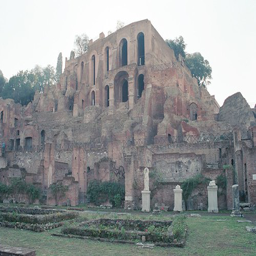

In [492]:
Image.open('data/train/TRAIN0016.png')

In [472]:
c[c.yolo_result == '10 persons5 horses']

,name,skin_tone,gender,age,n_faces,yolo_result
8541,TRAIN9991.png,monk_3,male,0_17,0,10 persons5 horses


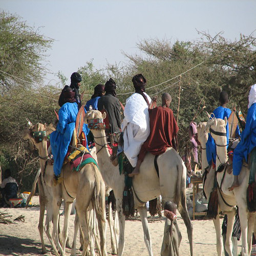

In [473]:
Image.open('data/train/TRAIN9991.png')

In [405]:
c.n_faces.value_counts()

0    5186
1    3359
2       3
Name: n_faces, dtype: int64

In [285]:
preds = b.label_encoder.inverse_transform(np.concatenate((skin_tone_preds, age_preds, gender_preds), axis=1))

In [223]:
probs['skin_tone'] == probs['skin_tone'].max(axis=1)

/tmp/ipykernel_6595/502213235.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  probs['skin_tone'] == probs['skin_tone'].max(axis=1)


False

In [46]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT * FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json = '"6308c400-0c97-4c05-b99c-8e6c71e4fc03"'
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'datetime_complete': '2022-12-02 13:30:11.781591',
 'datetime_start': '2022-12-02 13:20:16.509087',
 'distribution_json': '{"name": "IntDistribution", "attributes": {"log": '
                      'false, "step": 1, "low": 32, "high": 128}}',
 'key': 'model_id',
 'number': 6,
 'objective': 0,
 'param_id': 25,
 'param_name': 'batch_size',
 'param_value': 76.0,
 'state': 'COMPLETE',
 'study_id': 1,
 'trial_id': 7,
 'trial_user_attribute_id': 6,
 'trial_value_id': 7,
 'value': 6.424199907711928,
 'value_json': '"6308c400-0c97-4c05-b99c-8e6c71e4fc03"',
 'value_type': 'FINITE'}
{'datetime_complete': '2022-12-02 13:30:11.781591',
 'datetime_start': '2022-12-02 13:20:16.509087',
 'distribution_json': '{"name": "FloatDistribution", "attributes": {"step": '
                      'null, "low": 0.1, "high": 0.9, "log": false}}',
 'key': 'model_id',
 'number': 6,
 'objective': 0,
 'param_id': 27,
 'param_name': 'dropout',
 'param_value': 0.5358959484932468,
 'state': 'COMPLETE',
 'study_id': 1,
 

In [47]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT * FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json = '"3919e616-3a87-4b18-a058-d08a32a6a11d"'
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'datetime_complete': '2022-12-02 13:40:15.321443',
 'datetime_start': '2022-12-02 13:30:11.793683',
 'distribution_json': '{"name": "IntDistribution", "attributes": {"log": '
                      'false, "step": 1, "low": 32, "high": 128}}',
 'key': 'model_id',
 'number': 7,
 'objective': 0,
 'param_id': 29,
 'param_name': 'batch_size',
 'param_value': 128.0,
 'state': 'COMPLETE',
 'study_id': 1,
 'trial_id': 8,
 'trial_user_attribute_id': 7,
 'trial_value_id': 8,
 'value': 5.845763707378262,
 'value_json': '"3919e616-3a87-4b18-a058-d08a32a6a11d"',
 'value_type': 'FINITE'}
{'datetime_complete': '2022-12-02 13:40:15.321443',
 'datetime_start': '2022-12-02 13:30:11.793683',
 'distribution_json': '{"name": "FloatDistribution", "attributes": {"step": '
                      'null, "low": 0.1, "high": 0.9, "log": false}}',
 'key': 'model_id',
 'number': 7,
 'objective': 0,
 'param_id': 31,
 'param_name': 'dropout',
 'param_value': 0.12196803114406568,
 'state': 'COMPLETE',
 'study_id': 1,

In [69]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT param_name, param_value FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json = '"99eb6520-e0d2-48bf-84d6-e8a6694b260a"'
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'param_name': 'batch_size', 'param_value': 86.0}
{'param_name': 'dropout', 'param_value': 0.2882615326070268}
{'param_name': 'learning_rate', 'param_value': 5.500986147414477e-05}
{'param_name': 'unfreeze', 'param_value': 4.0}


In [70]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT param_name, param_value FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json = '"d54fadb4-5544-4dec-80b4-94b677cb33b6"'
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'param_name': 'batch_size', 'param_value': 68.0}
{'param_name': 'dropout', 'param_value': 0.10716026175721194}
{'param_name': 'learning_rate', 'param_value': 4.7627937165669094e-05}
{'param_name': 'unfreeze', 'param_value': 4.0}


In [71]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT param_name, param_value FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json = '"dad49637-d03b-4bc9-9db7-2a949a247496"'
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'param_name': 'batch_size', 'param_value': 101.0}
{'param_name': 'dropout', 'param_value': 0.31491577619954486}
{'param_name': 'learning_rate', 'param_value': 5.085680840353469e-05}
{'param_name': 'unfreeze', 'param_value': 4.0}


In [88]:
s = sqlite3.connect('studies_2.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT param_name, param_value FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json IN (
'"3919e616-3a87-4b18-a058-d08a32a6a11d"',
'"dba84a4f-67d7-45ff-9a63-9e397a40d8c8"',
'"d3f996c6-2f38-4b72-9f69-72251e738ac3"',
'"dacf3699-7b21-42bf-9af1-87c7bd784497"',
'"c511a68e-cef3-4d05-83c1-b7381e867b79"',
'"99eb6520-e0d2-48bf-84d6-e8a6694b260a"',
'"dad49637-d03b-4bc9-9db7-2a949a247496"',
'"c7696be7-eba8-4308-89c0-5999c2684da1"',
'"ed25027d-c5e5-464d-b496-dec4649e1b0d"',
'"91381695-ab9b-4091-a00c-c06a20558178"',
'"1e5e54ef-e0e8-4dd4-b948-8987f8bb79dc"',
'"4cfff6c0-2ac7-4b46-b257-0482996b1f74"',
'"edc4418d-4b4e-4969-ab70-a2bbe9491884"',
'"c77f927e-361a-40ce-a3e9-4daad503c3f3"',
'"5e89b28e-bd57-4e42-84f8-f5bc22309de6"',
'"b4a16165-d26e-4321-955f-ab1fe95ff033"',
'"83d2b352-0a7d-4a83-960e-98f176e7a680"',
'"07b10e97-0f8b-4d9d-9609-2aba5ce76c5e"'
)
ORDER BY param_name, param_value
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'param_name': 'batch_size', 'param_value': 69.0}
{'param_name': 'batch_size', 'param_value': 70.0}
{'param_name': 'batch_size', 'param_value': 74.0}
{'param_name': 'batch_size', 'param_value': 78.0}
{'param_name': 'batch_size', 'param_value': 83.0}
{'param_name': 'batch_size', 'param_value': 86.0}
{'param_name': 'batch_size', 'param_value': 91.0}
{'param_name': 'batch_size', 'param_value': 92.0}
{'param_name': 'batch_size', 'param_value': 94.0}
{'param_name': 'batch_size', 'param_value': 101.0}
{'param_name': 'batch_size', 'param_value': 109.0}
{'param_name': 'batch_size', 'param_value': 111.0}
{'param_name': 'batch_size', 'param_value': 128.0}
{'param_name': 'dropout', 'param_value': 0.10099862245352753}
{'param_name': 'dropout', 'param_value': 0.12196803114406568}
{'param_name': 'dropout', 'param_value': 0.13662742020436455}
{'param_name': 'dropout', 'param_value': 0.23651276718696926}
{'param_name': 'dropout', 'param_value': 0.26985268182664257}
{'param_name': 'dropout', 'param_val

In [602]:
s = sqlite3.connect('studies_6.db')
s.row_factory = sqlite3.Row
c = s.execute('''
SELECT param_name, param_value FROM trials 
JOIN trial_values ON trials.trial_id = trial_values.trial_id 
JOIN trial_user_attributes ON trial_user_attributes.trial_id = trials.trial_id
JOIN trial_params ON trial_params.trial_id = trials.trial_id
WHERE value_json IN ('"2b4a17bf-e34e-48d6-a72b-341a07352f15"')
''')

r = c.fetchall()

c.close()

s.close()
for row in r:
    pprint(dict(row))

{'param_name': 'dropout', 'param_value': 0.6614969697846855}
{'param_name': 'learning_rate', 'param_value': 2.3275079400186292e-05}


In [ ]:
'3919e616-3a87-4b18-a058-d08a32a6a11d',
 'dba84a4f-67d7-45ff-9a63-9e397a40d8c8',
 'd3f996c6-2f38-4b72-9f69-72251e738ac3',
 'dacf3699-7b21-42bf-9af1-87c7bd784497',
 'c511a68e-cef3-4d05-83c1-b7381e867b79',
 '99eb6520-e0d2-48bf-84d6-e8a6694b260a',
 'dad49637-d03b-4bc9-9db7-2a949a247496',
 'c7696be7-eba8-4308-89c0-5999c2684da1',
 'ed25027d-c5e5-464d-b496-dec4649e1b0d',
 '91381695-ab9b-4091-a00c-c06a20558178',
 '1e5e54ef-e0e8-4dd4-b948-8987f8bb79dc',
 '4cfff6c0-2ac7-4b46-b257-0482996b1f74',
 'edc4418d-4b4e-4969-ab70-a2bbe9491884',
 'c77f927e-361a-40ce-a3e9-4daad503c3f3',
 '5e89b28e-bd57-4e42-84f8-f5bc22309de6',
 'b4a16165-d26e-4321-955f-ab1fe95ff033',
 '83d2b352-0a7d-4a83-960e-98f176e7a680',
 '07b10e97-0f8b-4d9d-9609-2aba5ce76c5e',

In [48]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /home/justin/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to /home/justin/.cache/torch/hub/checkpoints/celebaHQ16_december_s7_i96000-9c72988c.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 264M/264M [00:10<00:00, 26.5MB/s]


Average network found !


In [52]:
model.netD

DNet(
  (scaleLayers): ModuleList(
    (0): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1)

In [14]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

In [11]:
import optuna

In [565]:
study = optuna.create_study(
        study_name="bias_bounty_study",
        storage="sqlite:////home/justin/projects/bias_bounty/studies_6.db",
        direction="minimize",
        load_if_exists=True,
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=6),
    )

[I 2022-12-04 19:16:07,719] Using an existing study with name 'bias_bounty_study' instead of creating a new one.


/tmp/ipykernel_533950/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

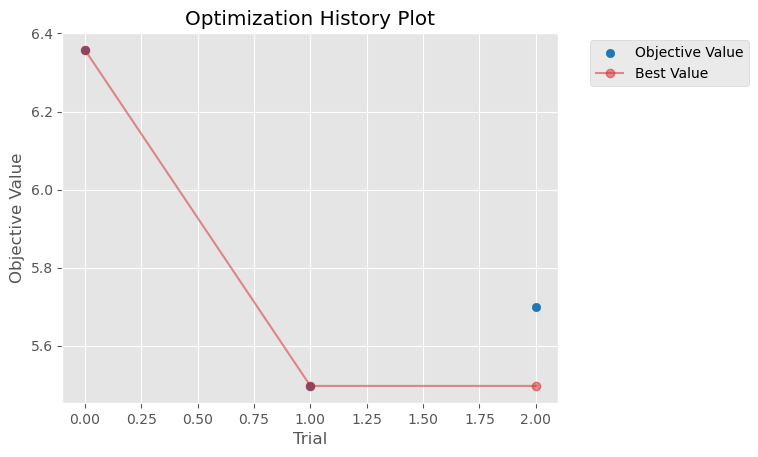

In [566]:
plot_optimization_history(study)

/tmp/ipykernel_533950/1019604185.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_parallel_coordinate(study)


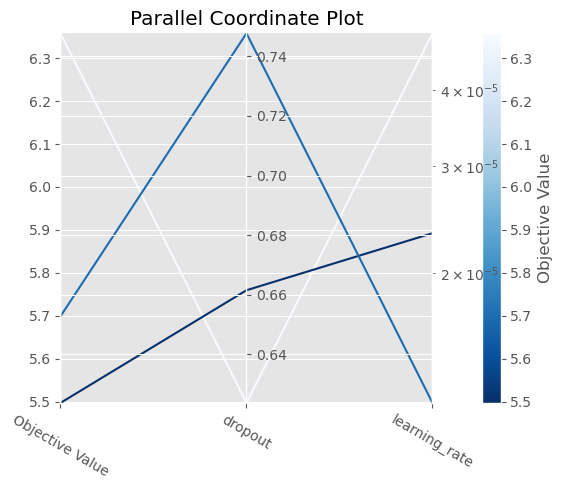

In [567]:
ax = plot_parallel_coordinate(study)

/tmp/ipykernel_533950/2394464243.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study);
[W 2022-12-04 19:16:10,969] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


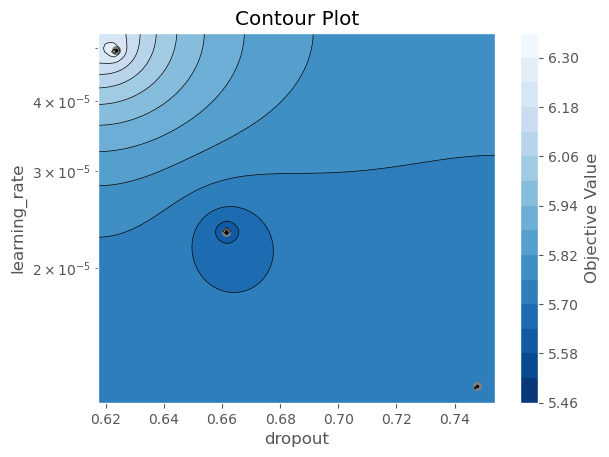

In [568]:
plot_contour(study);

/tmp/ipykernel_533950/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


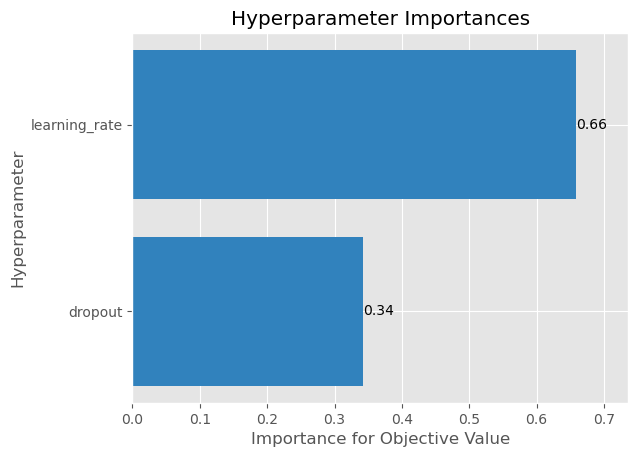

In [563]:
plot_param_importances(study);

## Score predictions

In [569]:
train = BiasBountyDataset('data/train')
test = BiasBountyDataset('raw_data/test', is_train=False)

In [585]:
probs = load('predictions/c21790dc-536e-44b9-8071-63586284bd6d_probs.pkl')
labels, object_i = load('predictions/c21790dc-536e-44b9-8071-63586284bd6d_labels.pkl')

In [492]:
i = 5

True: ['monk_6' '18_30' 'female']
Pred: ['monk_7', '18_30', 'female']


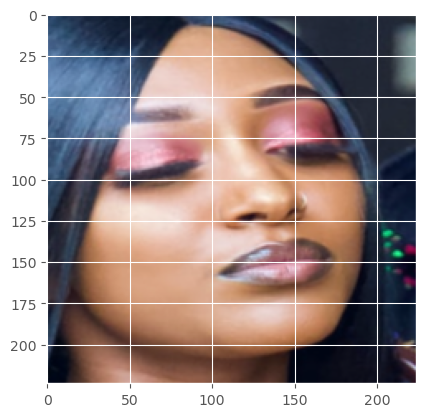

In [546]:
print(f"True: {test.get_label_words(i, ['skin_tone', 'age', 'gender'])}\nPred: {labels[i]}")
if i in object_i:
    print('Object')
show_image(test.get_image(i))
i+= 1

In [446]:
object_labels = [train.get_label(i)[-1] for i in range(len(train))]

In [589]:
skin_tone_preds = (probs['skin_tone'].max(axis=1).reshape(-1, 1).repeat(10, axis=1) == probs['skin_tone']).astype('int')
age_preds = (probs['age'].max(axis=1).reshape(-1, 1).repeat(4, axis=1) == probs['age']).astype('int')
gender_preds = (probs['gender'].max(axis=1).reshape(-1, 1).repeat(2, axis=1) == probs['gender']).astype('int')
#non_person_prods = (probs['person'].max(axis=1).reshape(-1, 1).repeat(2, axis=1) == probs['person']).astype('int')

In [590]:
skin_tone_preds.shape, age_preds.shape, gender_preds.shape

((3000, 10), (3000, 4), (3000, 2))

In [591]:
labels = np.array([test.get_label(i) for i in range(len(test))])
skin_tone_labels = labels[:,:10]
age_labels = labels[:,10:14]
gender_labels = labels[:,14:16]

In [592]:
results = {'accuracy': {}, 'disparity': {}}

In [593]:
acc = (skin_tone_labels.argmax(axis=1) == skin_tone_preds.argmax(axis=1)).mean()
results['accuracy']['skin_tone'] = acc
acc

0.293

In [594]:
acc = (age_labels.argmax(axis=1) == age_preds.argmax(axis=1)).mean()
results['accuracy']['age'] = acc
acc

0.6103333333333333

In [595]:
acc = (gender_labels.argmax(axis=1) == gender_preds.argmax(axis=1)).mean()
results['accuracy']['gender'] = acc
acc

0.8346666666666667

In [596]:
results['disparity']['skin_tone'] = disparity_score(skin_tone_labels.argmax(axis=1), skin_tone_preds.argmax(axis=1))

In [597]:
results['disparity']['age'] = disparity_score(age_labels.argmax(axis=1), age_preds.argmax(axis=1))

In [598]:
results['disparity']['gender'] = disparity_score(gender_labels.argmax(axis=1), gender_preds.argmax(axis=1))

In [413]:
results

{'accuracy': {'skin_tone': 0.2906666666666667,
  'age': 0.6093333333333333,
  'gender': 0.8396666666666667},
 'disparity': {'skin_tone': 0.27275031685678075,
  'age': 0.2257029909748639,
  'gender': 0.022324510932105857}}

In [599]:
results

{'accuracy': {'skin_tone': 0.293,
  'age': 0.6103333333333333,
  'gender': 0.8346666666666667},
 'disparity': {'skin_tone': 0.35842839036755386,
  'age': 0.2733268869444903,
  'gender': 0.05986679220281055}}

In [426]:
results

{'accuracy': {'skin_tone': 0.2906666666666667, 'age': 0.632, 'gender': 0.84},
 'disparity': {'skin_tone': 0.23381950395620302,
  'age': 0.19436648506717602,
  'gender': 0.0019527844614151135}}

In [107]:
baseline_results = {'accuracy': {
    'skin_tone': 0.25766666666666665,
    'age': 0.5783333333333334,
    'gender': 0.7966666666666666,
},
 'disparity': {
    'skin_tone': 0.5514223194748359,
    'age': 0.7802908824936,
    'gender': 0.1493182689960596,
}}

In [600]:
getScore(results)

6.741009676985357

In [31]:
print(classification_report(skin_tone_labels.argmax(axis=1), skin_tone_preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.23      0.24       169
           1       0.33      0.34      0.34       433
           2       0.31      0.30      0.30       545
           3       0.35      0.25      0.29       574
           4       0.34      0.33      0.34       457
           5       0.21      0.28      0.24       263
           6       0.28      0.28      0.28       256
           7       0.25      0.37      0.30       152
           8       0.21      0.22      0.22       106
           9       0.30      0.51      0.38        45

    accuracy                           0.30      3000
   macro avg       0.28      0.31      0.29      3000
weighted avg       0.30      0.30      0.30      3000



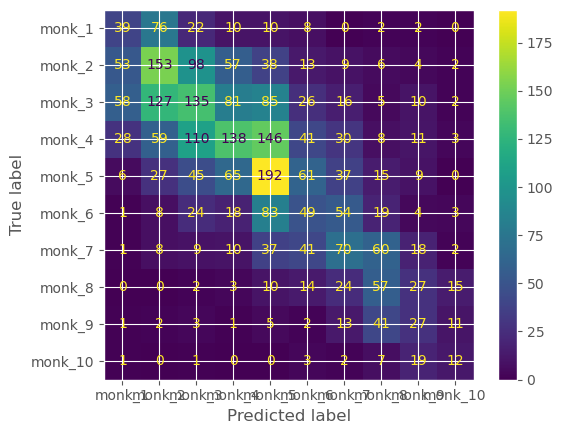

In [510]:
c = ConfusionMatrixDisplay(confusion_matrix(skin_tone_labels.argmax(axis=1), skin_tone_preds.argmax(axis=1)), display_labels=test.SKIN_TONES)

c.plot()

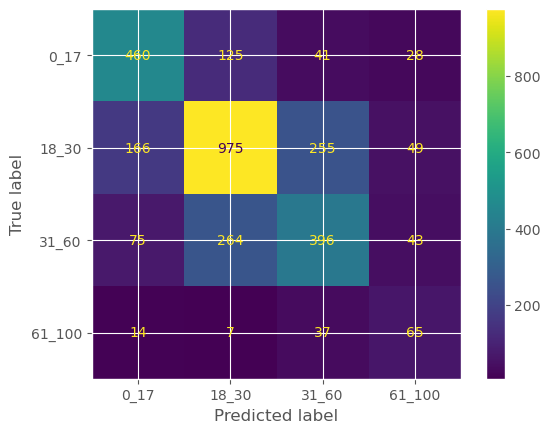

In [511]:
c = ConfusionMatrixDisplay(confusion_matrix(age_labels.argmax(axis=1), age_preds.argmax(axis=1)), display_labels=test.AGES)

c.plot()

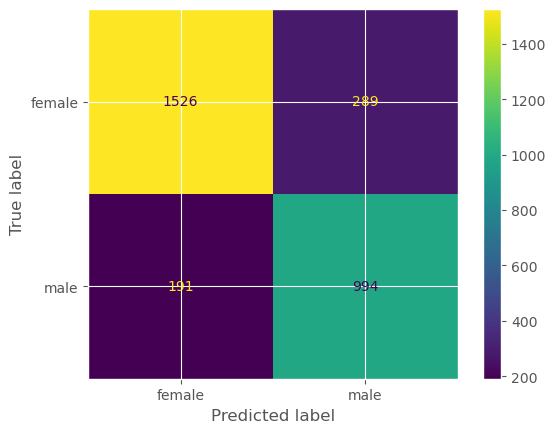

In [512]:
c = ConfusionMatrixDisplay(confusion_matrix(gender_labels.argmax(axis=1), gender_preds.argmax(axis=1)), display_labels=test.GENDERS)

c.plot()

In [623]:
getScore(baseline_results)

4.705572543130653

In [346]:
skin_tone_preds.argmax(axis=1)

array([5, 4, 2, ..., 3, 4, 3])

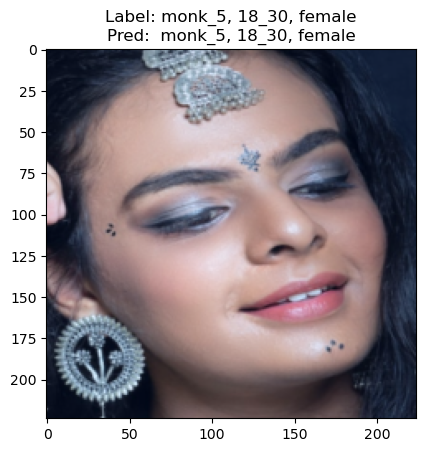

In [387]:
idx = 66
show_image(b[idx][0], title='Label: ' + ', '.join(b.get_label_words(idx)) + '\nPred:  ' + ', '.join(preds[idx]))

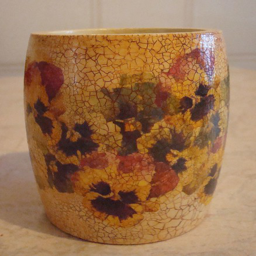

In [391]:
Image.open('data/train/TRAIN0001.png')

## Create class weights

In [691]:
import pandas as pd
train = pd.read_csv('data/train/labels.csv')

In [692]:
skin_tone_weights = 1 / train.skin_tone.value_counts() / (1/train.skin_tone.value_counts().max())
skin_tone_weight_vector = torch.Tensor(skin_tone_weights[b.SKIN_TONES].values)
skin_tone_weights[b.SKIN_TONES]

monk_1      3.307393
monk_2      1.326053
monk_3      1.000000
monk_4      1.096067
monk_5      1.325019
monk_6      2.689873
monk_7      2.449568
monk_8      3.505155
monk_9      5.882353
monk_10    14.406780
Name: skin_tone, dtype: float64

In [698]:
skin_tone_weight_vector

tensor([ 3.30739,  1.32605,  1.00000,  1.09607,  1.32502,  2.68987,  2.44957,  3.50515,  5.88235, 14.40678])

In [693]:
age_weights = 1 / train.age.value_counts() / (1/train.age.value_counts().max())
age_weights_vector = torch.Tensor(age_weights[b.AGES].values)
age_weights[b.AGES]

0_17       2.235263
18_30      1.000000
31_60      1.998588
61_100    15.387681
Name: age, dtype: float64

In [699]:
age_weights_vector

tensor([ 2.23526,  1.00000,  1.99859, 15.38768])

In [694]:
gender_weights = 1 / train.gender.value_counts() / (1/train.gender.value_counts().max())
gender_weights_vector = torch.Tensor(gender_weights[b.GENDERS].values)
gender_weights[b.GENDERS]

female    1.000000
male      1.481277
Name: gender, dtype: float64

In [700]:
gender_weights_vector

tensor([1.00000, 1.48128])

In [697]:
1 / train[['skin_tone', 'gender', 'age']].value_counts()

skin_tone  gender  age   
monk_3     female  18_30     0.001534
monk_4     female  18_30     0.001608
monk_2     female  18_30     0.002079
monk_5     female  18_30     0.002433
monk_3     female  31_60     0.003876
                               ...   
monk_9     male    61_100    0.166667
monk_10    male    61_100    0.250000
monk_1     male    61_100    0.250000
monk_10    female  61_100    0.500000
monk_9     female  61_100    1.000000
Length: 80, dtype: float64

In [648]:
skin_tone_weight_vector.unsqueeze(1)

tensor([[ 3.30739],
        [ 1.32605],
        [ 1.00000],
        [ 1.09607],
        [ 1.32502],
        [ 2.68987],
        [ 2.44957],
        [ 3.50515],
        [ 5.88235],
        [14.40678]])

In [659]:
def obs_weights(labels):
    return (
        (labels[:,:10] * skin_tone_weight_vector).sum(dim=1) + 
        (labels[:,10:14] * age_weights_vector).sum(dim=1) +
        (labels[:,14:16] * gender_weights_vector).sum(dim=1)
    )
labels = torch.Tensor([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
])
obs_weights(labels)

tensor([6.54266, 3.00000])

In [551]:
for i in range(len(b))

array(['monk_1', '18_30', 'female', False], dtype=object)

In [556]:
np.append(np.array([0, 0, 0]), 0)

array([0, 0, 0, 0])

In [196]:
b.label_encoder.fit_transform([['monk_1', '0_17', 'male']]).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]])

In [185]:
b.SKIN_TONES

['monk_1',
 'monk_2',
 'monk_3',
 'monk_4',
 'monk_5',
 'monk_6',
 'monk_7',
 'monk_8',
 'monk_9',
 'monk_10']

In [ ]:
b.la

In [186]:
b.labels_df

,name,skin_tone,gender,age
0,TRAIN0000.png,NaN,NaN,NaN
1,TRAIN0001.png,monk_1,female,18_30
2,TRAIN0002.png,monk_6,male,0_17
3,TRAIN0003.png,NaN,NaN,NaN
4,TRAIN0004.png,monk_3,male,0_17
...,...,...,...,...
12278,TRAIN9995.png,monk_9,female,18_30
12279,TRAIN9996.png,monk_4,female,18_30
12280,TRAIN9997.png,NaN,NaN,NaN
12281,TRAIN9998.png,monk_5,male,18_30


In [189]:
b.labels_df.gender.unique()

array([nan, 'female', 'male'], dtype=object)

In [719]:
show_image(b[415][0])

AttributeError: 'BiasBountyDataset' object has no attribute 'is_train'